In [56]:
using Distributions
using LowRankApprox
using RCall
using CSV
include("../code/datasim.jl");
include("../code/likelihood.jl");
include("../code/mixEM.jl");
include("../code/mixSQP.jl");
include("../code/mixsqpnew.jl");
include("../code/REBayes.jl");

In [59]:
srand(2018);
z    = normtmixdatasim(round(Int,1e4));
sd   = autoselectmixsd(z,nv = 50);
L    = normlikmatrix(z,sd = sd);
size(L)

(10000, 50)

In [36]:
outem  = mixEM(L,maxiter = 10);
outip  = REBayes(L);
outsqp = mixSQP(L,verbose = false);

In [62]:
@time xem, tem = mixEM(L,tol = 1e-4, maxiter = 1000);
@time xip, tip = REBayes(L);
@time outsqp   = mixsqp(L, lowrank_criterion = "by_rtol", verbose = false);
@time outsqp2  = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "none", verbose = false);

  2.416242 seconds (44.66 k allocations: 3.584 GiB, 17.87% gc time)
  0.482045 seconds (248 allocations: 10.594 KiB)
  0.097813 seconds (75.04 k allocations: 89.631 MiB, 15.72% gc time)
  0.224364 seconds (81.50 k allocations: 365.699 MiB, 20.03% gc time)


In [63]:
fem   = mixobjective(L,xem);
fip   = mixobjective(L,xip);
fsqp  = mixobjective(L,outsqp["x"]);
fsqp2 = mixobjective(L,outsqp2["x"]);
fbest = minimum([fem fip fsqp fsqp2]);
@printf "Difference between EM and best solutions:  %0.2e\n" fem - fbest
@printf "Difference between IP and best solutions:  %0.2e\n" fip - fbest
@printf "Difference between SQP and best solutions: %0.2e\n" fsqp - fbest
@printf "Difference between SQP2 and best solutions: %0.2e\n" fsqp2 - fbest

Difference between EM and best solutions:  8.93e+00
Difference between IP and best solutions:  4.72e+01
Difference between SQP and best solutions: 1.26e-10
Difference between SQP2 and best solutions: 0.00e+00


In [ ]:
t = zeros(4,20); f = zeros(4,20);

for i = 1:20
    nv = i * 50;
    srand(2019);
    z    = normtmixdatasim(round(Int,1e4));
    sd   = autoselectmixsd(z,nv = nv);
    L    = normlikmatrix(z,sd = sd);
    t[1,i] = @elapsed xem, tem = mixEM(L,tol = 1e-6, maxiter = nv * 10);
    t[2,i] = @elapsed xip, tip = REBayes(L);
    t[3,i] = @elapsed outsqp   = mixsqp(L, lowrank_criterion = "by_rtol", verbose = false);
    t[4,i] = @elapsed outsqp2  = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "none", verbose = false);
    fem   = mixobjective(L,xem);
    fip   = mixobjective(L,xip);
    fsqp  = mixobjective(L,outsqp["x"]);
    fsqp2 = mixobjective(L,outsqp2["x"]);
    fbest = minimum([fem fip fsqp fsqp2]);
    @printf "Difference between EM and best solutions:  %0.2e\n" fem - fbest
    @printf "Difference between IP and best solutions:  %0.2e\n" fip - fbest
    @printf "Difference between SQP and best solutions: %0.2e\n" fsqp - fbest
    @printf "Difference between SQP2 and best solutions: %0.2e\n" fsqp2 - fbest
    f[1,i] = copy(fem);
    f[2,i] = copy(fip);
    f[3,i] = copy(fsqp);
    f[4,i] = copy(fsqp2);
end

In [96]:
data1          = CSV.read("../data/comparison.txt", delim = ',');
data1[:method] = repeat(["mixEM";"KWDual";"mix-SQP (approx)";"mix-SQP (no-approx)"], outer = 20);
t              = Matrix{Float64}(reshape(data1[:t],4,20)');
f              = Matrix{Float64}(reshape(data1[:f],4,20)');

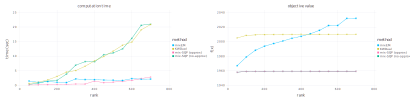

In [95]:
set_default_plot_size(41cm, 10.5cm)
p1 = Gadfly.plot(pdat, x = :m, y = :t, color = :method, shape = :method, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("time (sec)"),
                Guide.title("computation time"))
p2 = Gadfly.plot(pdat, x = :m, y = :f, color = :method, shape = :method, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("f(x)"),
                Guide.title("objective value"))
F  = hstack(p1,p2);
draw(PDF("fig3.pdf"), F)
F